# Imports

In [126]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tf_keras as k
from tf_keras.layers import *
from tf_keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler

from modules import train_model, plot_time_series, evaluate_preds, save_dict_to_json, plot_loss_and_prediction, get_results_table

import matplotlib.pyplot as plt

# Load Datasets

loading them in pandas

In [127]:
PATH = 'data/'
columns_to_drop = ['Date', 'Open', 'High', 'Low', 'Close + 7', 'Close + 8', 'Close + 9', 'Close + 10', 'Close + 11',
       'Close + 12', 'Close + 13', 'Close + 14', 'Close + 15',
       'Close + 16', 'Close + 17', 'Close + 18', 'Close + 19',
       'Close + 20', 'Close + 21', 'Close + 22', 'Close + 23',
       'Close + 24', 'Close + 25', 'Close + 26', 'Close + 27',
       'Close + 28', 'Close + 29', 'Close + 30']
train_df = pd.read_csv(PATH+'train_dataset.csv').drop(columns=columns_to_drop)
valid_df = pd.read_csv(PATH+'valid_dataset.csv').drop(columns=columns_to_drop)
test_df = pd.read_csv(PATH+'test_dataset.csv').drop(columns=columns_to_drop)

In [128]:
train_df.head(3)

,Volume,value,value_classification,Close + 1,Close + 2,Close + 3,Close + 4,Close + 5,Close + 6,MA_13,MA_21,RSI_3,%K,%D,Close
0,6690570240,56,4,11086.400391,10951.000000,10397.900391,10725.599609,10366.700195,9664.730469,10624.661659,10254.042015,100.0,100.0,100.0,11489.700195
1,6084149760,44,1,11489.700195,11086.400391,10951.000000,10397.900391,10725.599609,10366.700195,10646.761644,10415.119606,100.0,100.0,100.0,11512.599609
2,6468539904,55,4,11512.599609,11489.700195,11086.400391,10951.000000,10397.900391,10725.599609,10659.807767,10541.154343,100.0,100.0,100.0,11573.299805


In [129]:
train_df.columns.values

array(['Volume', 'value', 'value_classification', 'Close + 1',
       'Close + 2', 'Close + 3', 'Close + 4', 'Close + 5', 'Close + 6',
       'MA_13', 'MA_21', 'RSI_3', '%K', '%D', 'Close'], dtype=object)

turning datasets into np.array

In [130]:
scaler = MinMaxScaler()

In [131]:
columns_to_scale = ['Volume', 'value', 'Close + 1',
       'Close + 2', 'Close + 3', 'Close + 4', 'Close + 5', 'Close + 6',
        'MA_13', 'MA_21',
       'RSI_3', '%K', '%D', 'Close']
train_df[columns_to_scale] = scaler.fit_transform(train_df[columns_to_scale])
valid_df[columns_to_scale] = scaler.transform(valid_df[columns_to_scale])
test_df[columns_to_scale] = scaler.transform(test_df[columns_to_scale])

X_train, y_train = np.array(train_df.iloc[:, :-1]), np.array(train_df.iloc[:, -1]) 
X_valid, y_valid = np.array(valid_df.iloc[:, :-1]), np.array(valid_df.iloc[:, -1]) 
X_test, y_test = np.array(test_df.iloc[:, :-1]), np.array(test_df.iloc[:, -1])

X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_valid = np.reshape(X_valid, (X_valid.shape[0], 1, X_valid.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [132]:
# Fast save function
def fast_save(model, model_name):
    y_train_pred = model.predict(X_train, verbose=0)
    y_valid_pred = model.predict(X_valid, verbose=0)
    y_test_pred = model.predict(X_test, verbose=0)
    save_dict_to_json(evaluate_preds(y_train, y_train_pred), filename=f'results/train/{model_name}.json')
    save_dict_to_json(evaluate_preds(y_valid, y_valid_pred), filename=f'results/valid/{model_name}.json')
    save_dict_to_json(evaluate_preds(y_test, y_test_pred), filename=f'results/test/{model_name}.json')

# Training

## Naive forecasting

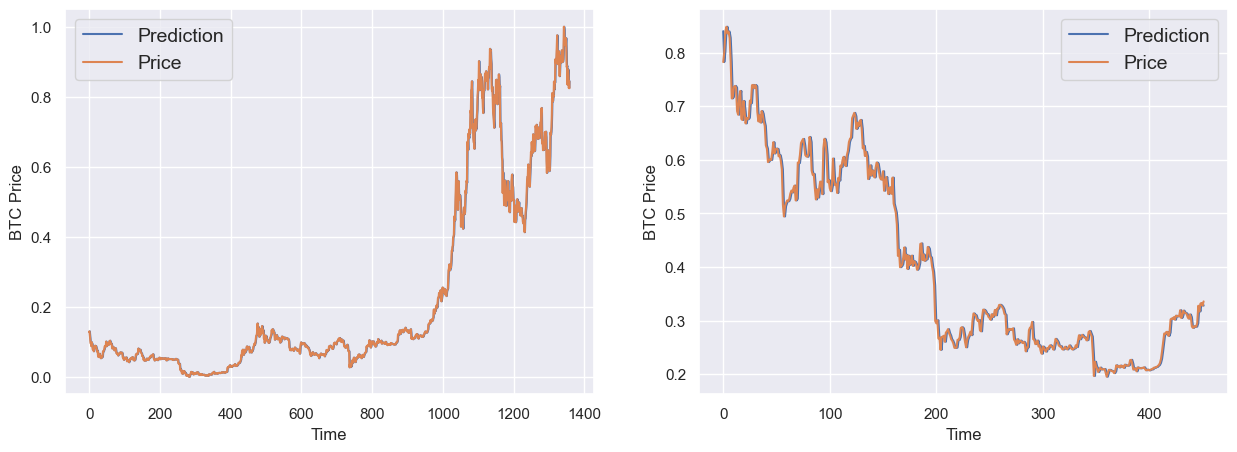

In [133]:
y_naive_train = y_train[:-1]
y_naive_valid = y_valid[:-1]

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plot_time_series(y_naive_train, format='-', label='Prediction')
plot_time_series(y_train[1:], format='-', label='Price')
plt.subplot(1, 2, 2)
plot_time_series(y_naive_valid, format='-', label='Prediction')
plot_time_series(y_valid[1:], format='-', label='Price')

In [135]:
save_dict_to_json(evaluate_preds(y_train[1:], y_naive_train), filename='results/train/naive.json')
save_dict_to_json(evaluate_preds(y_valid[1:], y_naive_valid), filename='results/valid/naive.json')

In [136]:
callback = [k.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')]
metrics=[k.metrics.MeanSquaredError(), 
         k.metrics.RootMeanSquaredError(),
         k.metrics.MeanAbsolutePercentageError(),
         k.metrics.MeanAbsoluteError()]
loss_fn = k.losses.MeanSquaredError()

## LSTM

In [137]:
model_0 = Sequential([
    LSTM(units=64, 
         input_shape=(1, X_train.shape[2]), 
         activation='relu'),
    Dense(units=1)
])

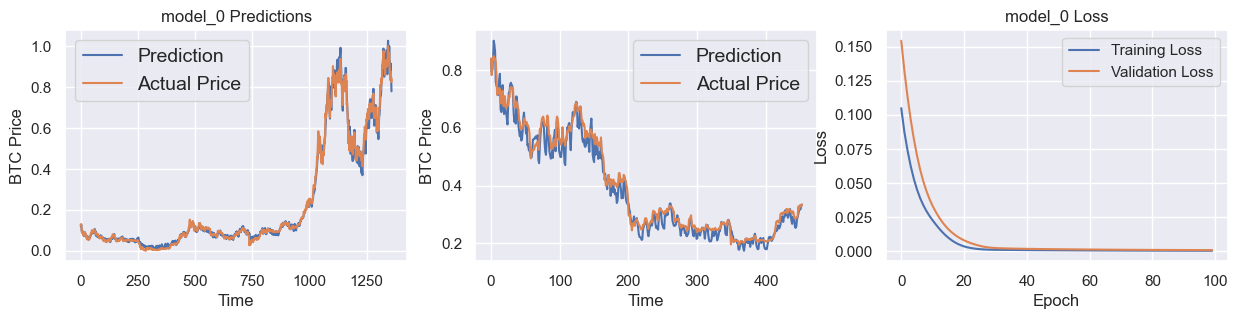

In [138]:
tf.random.set_seed(42)
model_0_history = train_model(
    model=model_0,
    model_name='model_0',
    loss_fn=loss_fn,
    optimizer=k.optimizers.Adam(learning_rate=1e-4),
    metrics=metrics,
    X_train=X_train,
    y_train=y_train, 
    batch_size=32,
    epochs=100,
    validation_data=(X_valid, y_valid),
    shuffle=False,
    verbose=0,
    callbacks=callback
)
fast_save(model_0, 'model_0_LSTM')

## Bidirectional LSTM

In [139]:
model_1 = Sequential([
    Bidirectional(LSTM(units=64, 
                       input_shape=(1, X_train.shape[2]), 
                       activation='relu')),
    Dense(1),
])

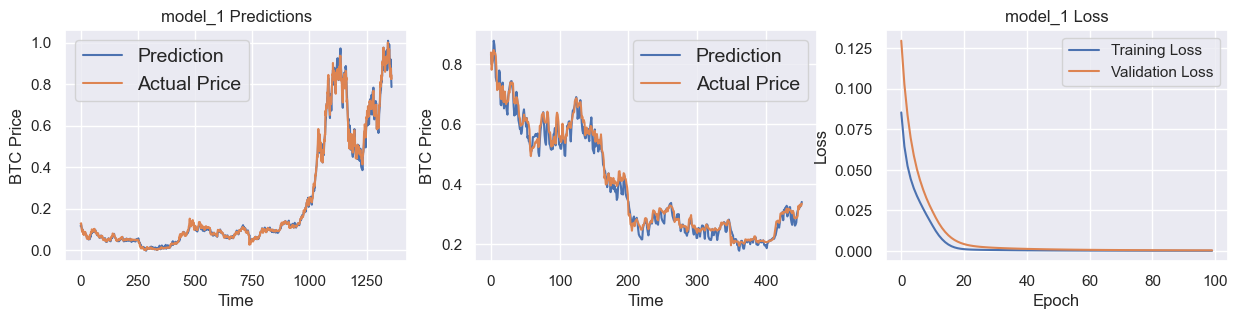

In [140]:
tf.random.set_seed(42)
model_1_history = train_model(
    model=model_1,
    model_name='model_1',
    loss_fn=loss_fn,
    optimizer=k.optimizers.Adam(learning_rate=1e-4),
    metrics=metrics,
    X_train=X_train,
    y_train=y_train, 
    batch_size=32,
    epochs=100,
    validation_data=(X_valid, y_valid),
    shuffle=False,
    verbose=0,
    callbacks=callback
)
fast_save(model_1, 'model_1_BiLSTM')

## Encoder-Decoder LSTM

In [141]:
model_2 = Sequential([
    LSTM(units=64, 
         input_shape=(1, X_train.shape[2]), 
         activation='relu'),
    RepeatVector(1),
    LSTM(64, 
         activation='relu'),
    Dense(1),
])

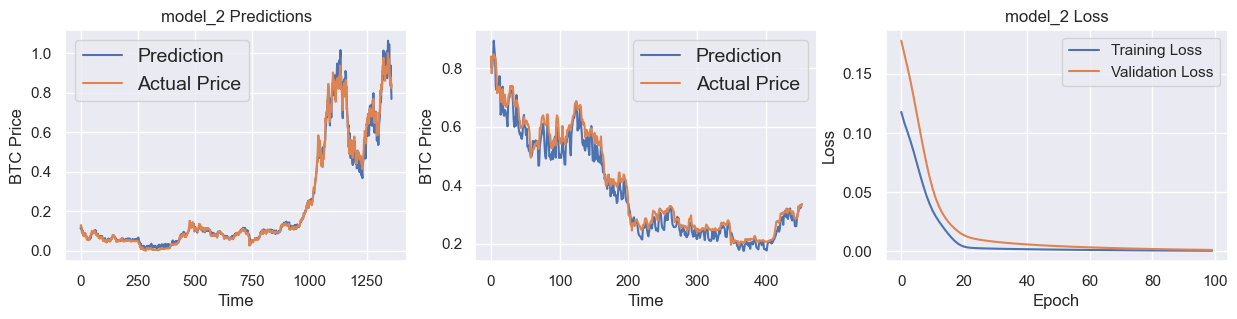

In [142]:
tf.random.set_seed(42)
model_2_history = train_model(
    model=model_2,
    model_name='model_2',
    loss_fn=loss_fn,
    optimizer=k.optimizers.Adam(learning_rate=1e-4),
    metrics=metrics,
    X_train=X_train,
    y_train=y_train, 
    batch_size=32,
    epochs=100,
    validation_data=(X_valid, y_valid),
    shuffle=False,
    verbose=0,
    callbacks=callback
)
fast_save(model_2, 'model_2_EDLSTM')

## Convolutional LSTM

In [143]:
model_3 = Sequential([
    Conv1D(
         filters=64,
         kernel_size=1, 
         activation='relu',
         input_shape=(1, X_train.shape[2]),
    ),
    LSTM(64,
         activation='relu',
    ),
    Dense(20, activation='relu'),
    Dense(1)
])

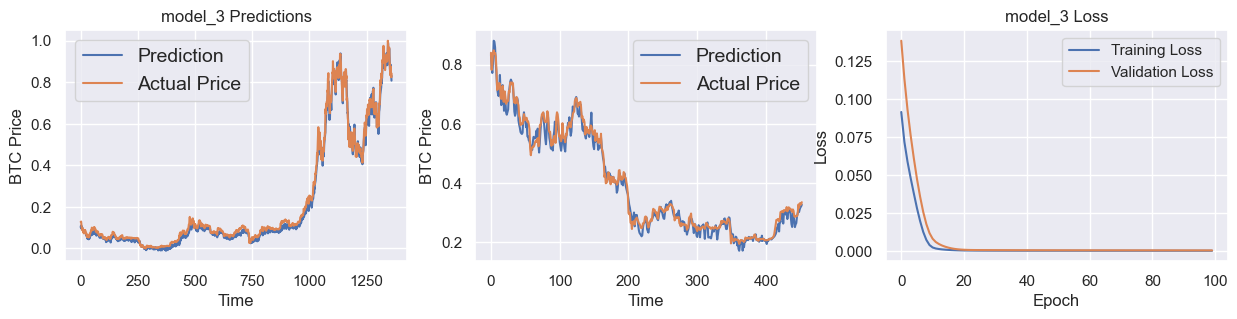

In [144]:
tf.random.set_seed(42)
model_3_history = train_model(
    model=model_3,
    model_name='model_3',
    loss_fn=loss_fn,
    optimizer=k.optimizers.Adam(learning_rate=1e-4),
    metrics=metrics,
    X_train=X_train,
    y_train=y_train, 
    batch_size=32,
    epochs=100,
    validation_data=(X_valid, y_valid),
    shuffle=False,
    verbose=0,
    callbacks=callback
)
fast_save(model_3, 'model_3_ConvLSTM')

## Comparison of each model

### Train

In [145]:
train_res_dir = 'results/train'
train_results = get_results_table(train_res_dir)
train_results

,mae,mse,rmse,mape,mase,model
0,0.011759,0.000318,0.011759,16903.478516,33.269585,model_0_LSTM
1,0.008112,0.000182,0.008112,6319.758789,33.453079,model_1_BiLSTM
2,0.012456,0.000404,0.012456,14515.567383,33.241829,model_2_EDLSTM
3,0.015328,0.000361,0.015328,933.828979,33.455498,model_3_ConvLSTM
4,0.007846,0.000237,0.015406,71.689896,0.999298,naive


### Valid

In [146]:
valid_res_dir = 'results/valid'
valid_results = get_results_table(valid_res_dir)
valid_results

,mae,mse,rmse,mape,mase,model
0,0.021846,0.000806,0.021846,5.635898,18.663931,model_0_LSTM
1,0.015634,0.000437,0.015634,4.046823,18.646578,model_1_BiLSTM
2,0.026607,0.001123,0.026607,6.837684,18.551855,model_2_EDLSTM
3,0.015759,0.000412,0.015759,4.163868,18.644114,model_3_ConvLSTM
4,0.010445,0.000267,0.016341,2.548672,1.010110,naive


# Testing

## Naive Forecast

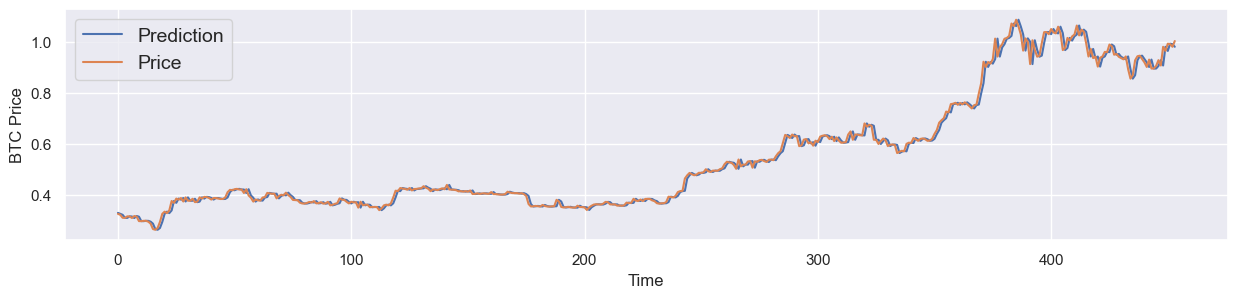

In [149]:
y_naive_test = y_test[:-1]
plt.figure(figsize=(15, 3))
plot_time_series(y_naive_test, format='-', label='Prediction')
plot_time_series(y_test[1:], format='-', label='Price')
save_dict_to_json(evaluate_preds(y_test[1:], y_naive_test), filename='results/test/naive.json')

## LSTM

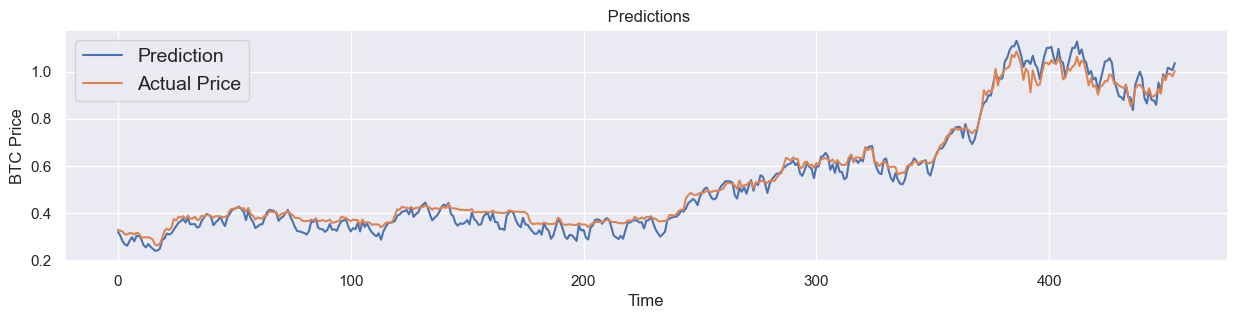

In [150]:
plot_loss_and_prediction(model_0,
                         X_test,
                         y_test)

## Bidirectional LSTM

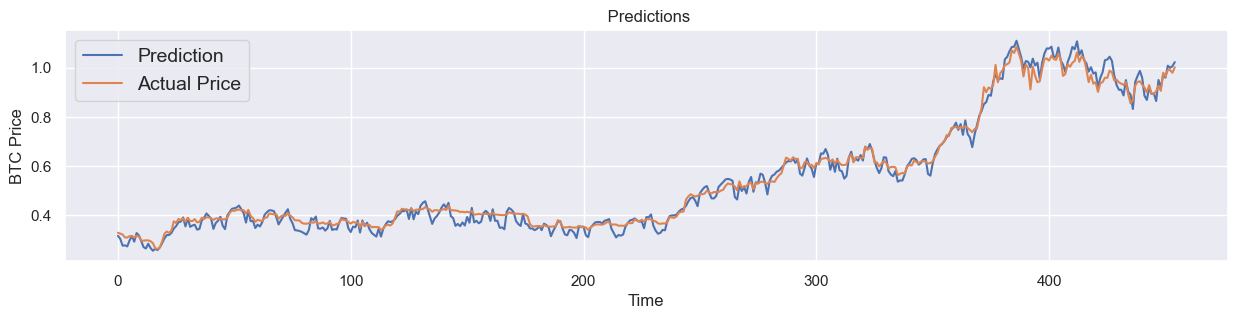

In [151]:
plot_loss_and_prediction(model_1,
                         X_test,
                         y_test)

## Encoder-Decoder LSTM

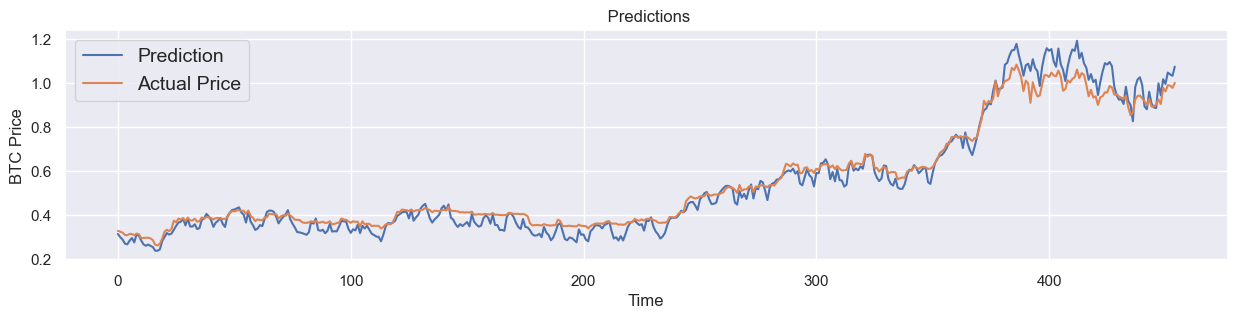

In [152]:
plot_loss_and_prediction(model_2,
                         X_test,
                         y_test)

## Convolutional LSTM

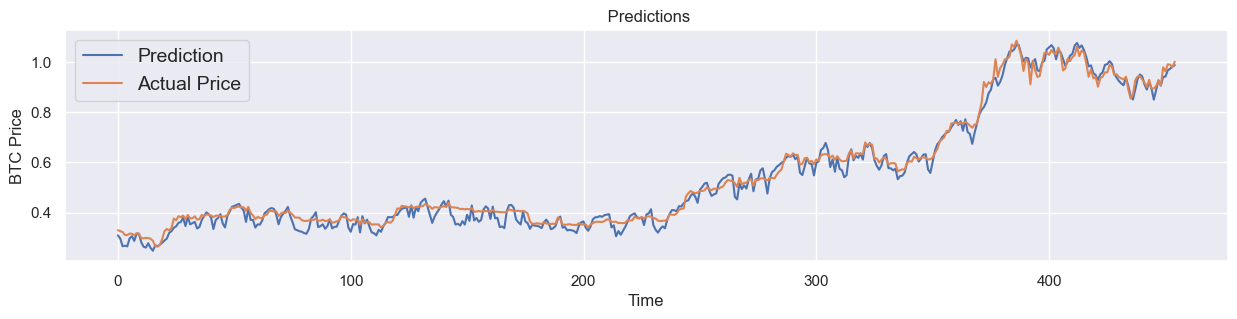

In [153]:
plot_loss_and_prediction(model_3,
                         X_test,
                         y_test)

## Comparison of each model

In [154]:
test_res_dir = 'results/test'
test_results = get_results_table(test_res_dir)
test_results

,mae,mse,rmse,mape,mase,model
0,0.018477,0.000517,0.018477,3.817050,21.940102,BiLSTM_128
1,0.026270,0.001066,0.026270,5.403903,22.633703,model_0_LSTM
2,0.020174,0.000635,0.020174,4.023596,22.155231,model_1_BiLSTM
3,0.033519,0.001899,0.033519,6.384579,23.161751,model_2_EDLSTM
4,0.020956,0.000687,0.020956,4.414897,21.965046,model_3_ConvLSTM
5,0.011246,0.000333,0.018238,1.890837,0.998550,naive
